# What drives the price of a car?

![](https://github.com/Pankil-Patel/practical_application_II/blob/main/images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src=https://github.com/Pankil-Patel/practical_application_II/blob/main/images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

### Understanding of business task in terms of data

The key task is to perform a regression analysis on the car price data set, using various features such as mileage, age, model, brand, etc. as predictors. The objective is to identify the most significant factors that influence the car price and to quantify their effects. The output of the analysis should be a report that summarizes the main findings and provides actionable insights to the client, a used car dealership, on how to price their cars competitively and attractively for the consumers.

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

### Key Steps to evaluate the data

1. Load the data
2. Review all the data types of the data
3. Review how many records have Null or NaN values
4. Review how many duplicate records
5. Review which records are bad and how to clean the data i.e. Remove the records with null values, replace the records which have nulls with specific values for the columns, replace data which are not in a right format to proper format, etc.

In [1]:
# import sys
# !{sys.executable} -m pip install missingno

Defaulting to user installation because normal site-packages is not writeable


In [6]:
#Import Key Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import missingno as msno
import warnings
from warnings import filterwarnings 
filterwarnings('ignore')

from scipy.linalg import svd
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, OrdinalEncoder, PolynomialFeatures   
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score, max_error, median_absolute_error, mean_squared_log_error
from sklearn.feature_selection import SequentialFeatureSelector, RFE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [7]:
#Loading of vehicles data and reviewing the data field types and snapshot of data
df = pd.read_csv('data/vehicles.csv')
df.set_index('id', inplace=True)
print(df.shape[0])
df.head(5)

426880


,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
id,,,,,,,,,,,,,,,,,
7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


<Axes: >

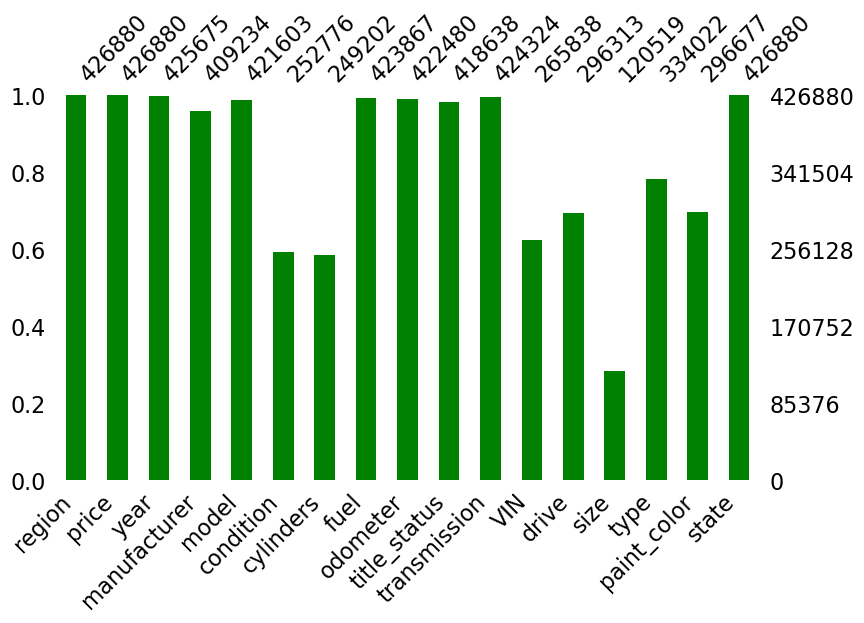

In [5]:
fig = plt.figure(figsize=(20, 5))
msno.bar(df, color="green", ax=fig.add_subplot(1,2,1))

Total duplicates removed: 56202


<Axes: >

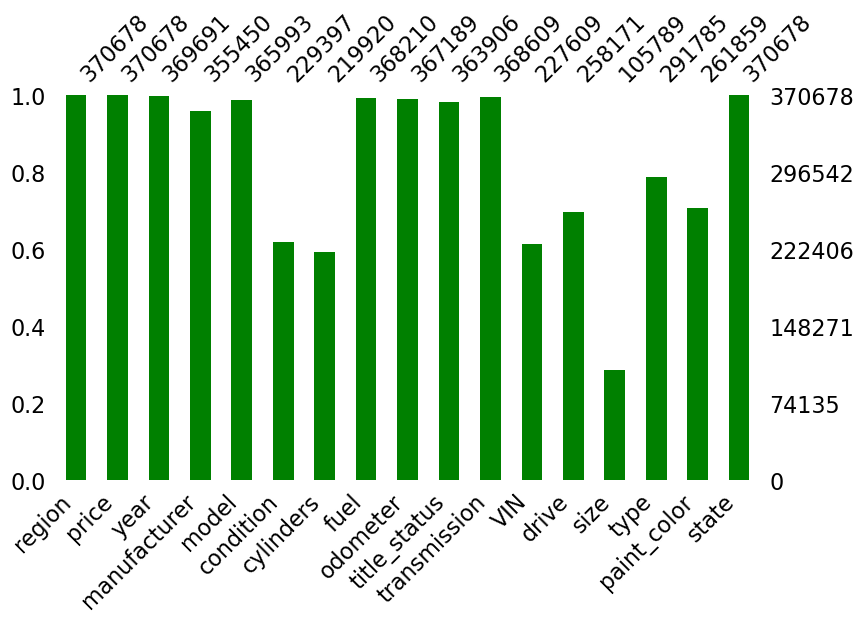

In [9]:
# remove initial duplicate rows
df_wo_dup = df.drop_duplicates()
total_reduced_rows = df.shape[0] - df_wo_dup.shape[0]
print(f"Total duplicates removed: {total_reduced_rows}")
fig = plt.figure(figsize=(20, 5))
msno.bar(df_wo_dup, color="green", ax=fig.add_subplot(1,2,1))

Based on the above output graph, we still have some key columns with missing values. We will prefill some of them and drop the rest. i.e. VIN should not affect the price of the vehicle. Size should not impact since type will determine the car.

In [10]:
# check if vin, price and odometer have unique values or not
df_clean = df_wo_dup.drop('VIN', axis=1).drop('size', axis=1)
df_clean = df_clean[df_clean['price'].notna()]
df_clean = df_clean[df_clean['price'] > 0]
df_clean = df_clean[df_clean['odometer'].notna()]
df_clean = df_clean[df_clean['odometer'] > 0]
df_clean = df_clean.drop('region',axis=1)
df_clean = df_clean.drop('state', axis=1)
df_clean = df_clean.drop('model', axis=1)
df_clean = df_clean.dropna()
#df_clean = df_wo_dup.drop_duplicates(subset=['VIN', 'price', 'odometer'])
print(df_clean.shape) 


(101646, 12)


In [11]:
# Assuming df is the original DataFrame and df_wo_dup is the DataFrame without duplicates
original_count = df.shape[0]
new_count = df_clean.shape[0]

# Subtract the counts
difference = original_count - new_count

print(f"The original DataFrame had {original_count} rows.")
print(f"The DataFrame without duplicates has {new_count} rows.")
print(f"The difference in row count is {difference}.")

The original DataFrame had 426880 rows.
The DataFrame without duplicates has 101646 rows.
The difference in row count is 325234.


<Axes: >

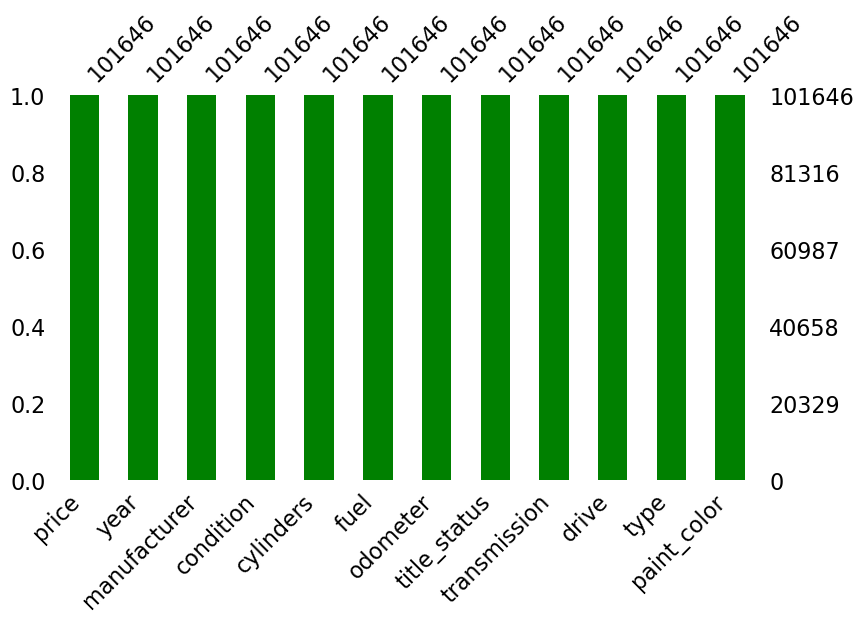

In [12]:
#Count number of NaN values
fig = plt.figure(figsize=(20, 5))
msno.bar(df_clean, color="green", ax=fig.add_subplot(1,2,1))

In [8]:
# get unique values for each column to understand what kind of data each of them have and which ones can be cleaned up vs. 
# which records with null values can be removed
unique_values = {col: df_clean[col].unique() for col in df_clean.columns}

unique_values

{'price': array([15000, 27990, 34590, ..., 46350,  3670, 27294], dtype=int64),
 'year': array([2013., 2012., 2016., 2019., 2011., 2017., 2018., 2004., 2001.,
        2014., 2003., 2008., 2007., 2020., 2006., 2005., 2010., 2009.,
        2002., 1995., 1974., 1996., 1955., 1972., 2021., 1994., 1988.,
        2015., 2000., 1979., 1984., 1998., 1999., 1978., 1937., 1976.,
        1991., 1953., 1963., 1968., 1997., 1993., 1990., 1982., 1948.,
        1986., 1985., 1951., 1936., 1966., 1989., 1967., 1981., 1947.,
        1992., 1962., 1973., 1975., 1958., 1964., 1934., 1977., 1971.,
        1946., 1957., 1987., 1930., 1969., 1980., 1959., 1965., 1928.,
        1933., 1960., 1970., 1929., 1932., 1956., 1924., 1927., 1952.,
        1939., 1983., 1923., 1940., 1961., 1918., 1950., 1949., 1900.,
        1931., 1926., 1938., 1942., 1913., 1954., 2022., 1935., 1941.,
        1922., 1905., 1925., 1916., 1944.]),
 'manufacturer': array(['ford', 'gmc', 'chevrolet', 'toyota', 'jeep', 'nissan', 'honda'

In [9]:
# Looking at the data, some obvious data clean ups.
# 1. Replace "." to empty string in  Model Year
# 2. Remove any NaN from Manufacturer
# 3. Remove any NaN from Condition
# 4. Remove any NaN from Cylinders
# 5. Remove any NaN from Fuel
# 6. Remove any NaN from Size
# 7. Remove any NaN from Type
# 8. Remove any NaN from Drive


In [8]:
# replace model year "." with ""
df_clean['year'] = df_clean['year'].replace('\.', '', regex=True)
df_clean['year'] = pd.to_numeric(df_clean['year'], errors='coerce').fillna(0).astype(int)

# replace cylinders in data
df_clean['cylinders'] = df_clean['cylinders'].replace('\ cylinders', '', regex=True)
df_clean['cylinders'] = df_clean['cylinders'].replace('others', '0', regex=True)
df_clean['cylinders'] = pd.to_numeric(df_clean['cylinders'], errors='coerce').fillna(0).astype(int)
df_clean.head()

,price,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color
id,,,,,,,,,,,,
7316356412,15000,2013,ford,excellent,6,gas,128000.0,clean,automatic,rwd,truck,black
7316343444,27990,2012,gmc,good,8,gas,68696.0,clean,other,4wd,pickup,black
7316304717,34590,2016,chevrolet,good,6,gas,29499.0,clean,other,4wd,pickup,silver
7316285779,35000,2019,toyota,excellent,6,gas,43000.0,clean,automatic,4wd,truck,grey
7316257769,29990,2016,chevrolet,good,6,gas,17302.0,clean,other,4wd,pickup,red


In [9]:
# Replace all the null values in all columns+
#df_clean = df_clean.dropna()
nan_counts = df_clean.isna().sum()
print(nan_counts)
df_clean.info()
df_clean.shape
# 34868 entries remaining of 426836

price           0
year            0
manufacturer    0
condition       0
cylinders       0
fuel            0
odometer        0
title_status    0
transmission    0
drive           0
type            0
paint_color     0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 101646 entries, 7316356412 to 7301591140
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         101646 non-null  int64  
 1   year          101646 non-null  int32  
 2   manufacturer  101646 non-null  object 
 3   condition     101646 non-null  object 
 4   cylinders     101646 non-null  int32  
 5   fuel          101646 non-null  object 
 6   odometer      101646 non-null  float64
 7   title_status  101646 non-null  object 
 8   transmission  101646 non-null  object 
 9   drive         101646 non-null  object 
 10  type          101646 non-null  object 
 11  paint_color   101646 non-null  object 
dtypes: float64(1), int32(2), i

(101646, 12)

### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [12]:
df_clean.head(10)
df_clean.tail(10)

,price,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color
id,,,,,,,,,,,,
7302487313,37590,2018,mercedes-benz,good,6,gas,16482.0,clean,automatic,rwd,SUV,black
7302384818,9800,1985,nissan,like new,6,gas,115000.0,clean,automatic,rwd,hatchback,red
7302338378,6800,1997,jaguar,good,8,gas,69550.0,clean,automatic,rwd,convertible,white
7301954392,41990,2019,toyota,good,6,gas,36630.0,clean,other,4wd,SUV,white
7301953587,51990,2020,cadillac,good,6,gas,6814.0,clean,other,fwd,other,black
7301952155,48590,2020,cadillac,good,6,gas,7701.0,clean,other,fwd,other,black
7301951544,39990,2017,infiniti,good,8,gas,41664.0,clean,automatic,4wd,other,black
7301949190,32990,2016,infiniti,good,8,gas,55612.0,clean,automatic,rwd,other,black
7301591199,33590,2018,lexus,good,6,gas,30814.0,clean,automatic,rwd,sedan,white


In [13]:
def get_unique_values(df, columns):
    unique_values = {column: df[column].unique() for column in columns}
    return unique_values

# Assuming 'columns_to_check' is a list of the column names you want to check
columns_to_check = ['manufacturer', 'condition', 'cylinders']
unique_values = get_unique_values(df, columns_to_check)

for column, values in unique_values.items():
    print(f"The unique values in the {column} column are: {values}")

The unique values in the manufacturer column are: [nan 'gmc' 'chevrolet' 'toyota' 'ford' 'jeep' 'nissan' 'ram' 'mazda'
 'cadillac' 'honda' 'dodge' 'lexus' 'jaguar' 'buick' 'chrysler' 'volvo'
 'audi' 'infiniti' 'lincoln' 'alfa-romeo' 'subaru' 'acura' 'hyundai'
 'mercedes-benz' 'bmw' 'mitsubishi' 'volkswagen' 'porsche' 'kia' 'rover'
 'ferrari' 'mini' 'pontiac' 'fiat' 'tesla' 'saturn' 'mercury'
 'harley-davidson' 'datsun' 'aston-martin' 'land rover' 'morgan']
The unique values in the condition column are: [nan 'good' 'excellent' 'fair' 'like new' 'new' 'salvage']
The unique values in the cylinders column are: [nan '8 cylinders' '6 cylinders' '4 cylinders' '5 cylinders' 'other'
 '3 cylinders' '10 cylinders' '12 cylinders']


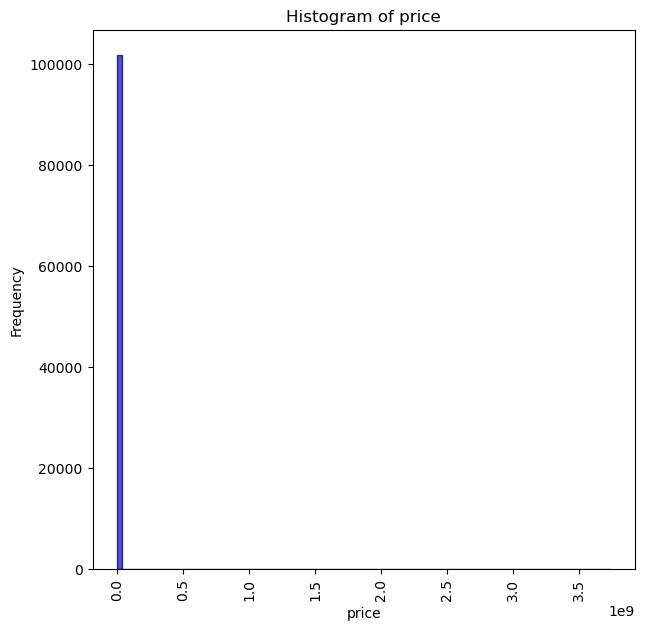

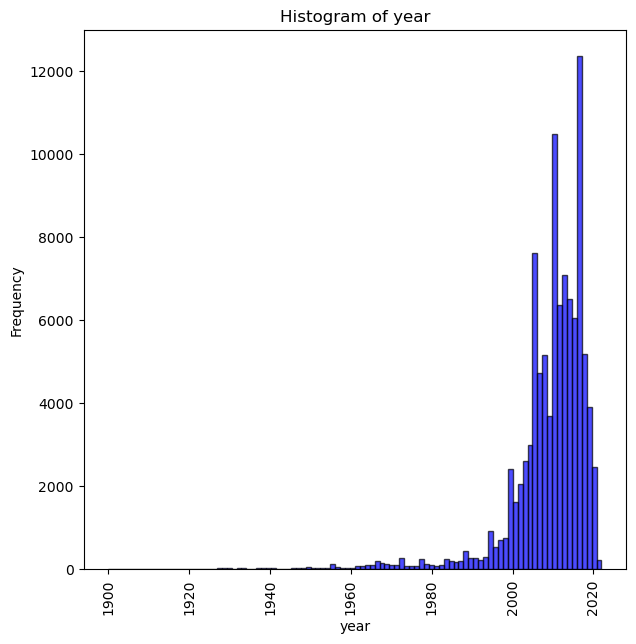

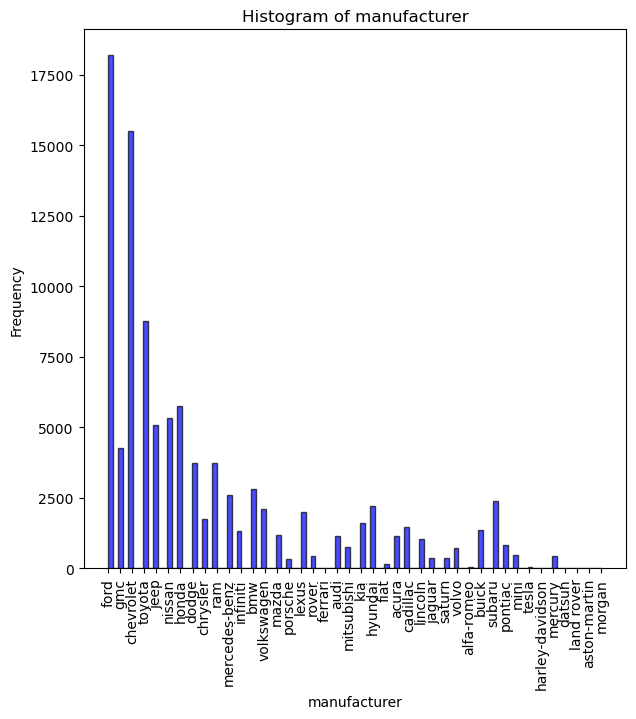

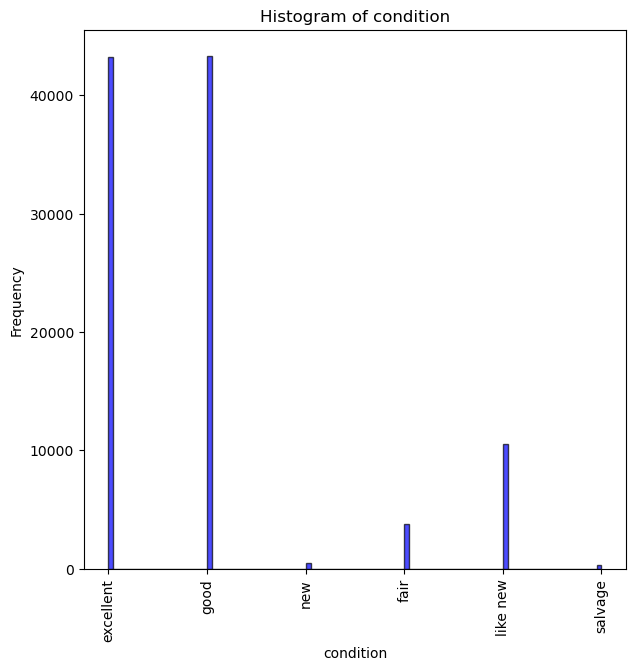

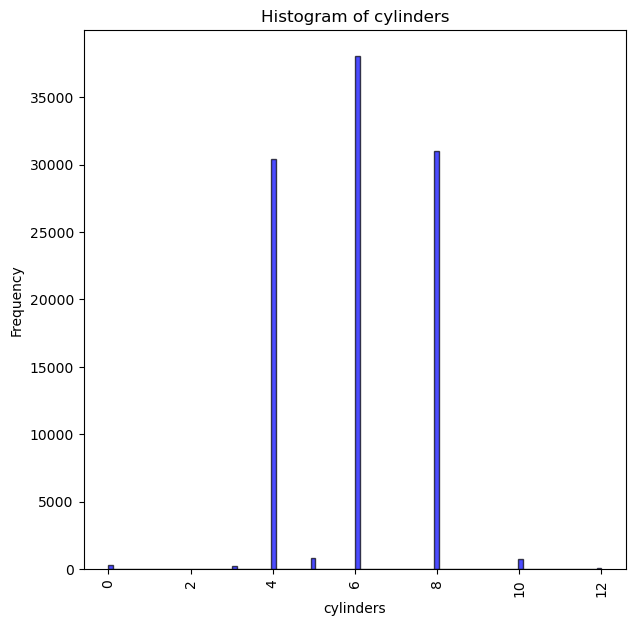

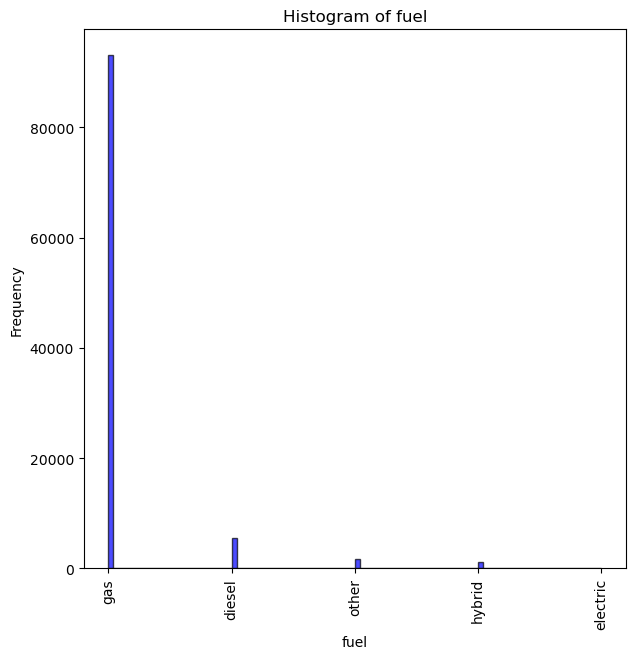

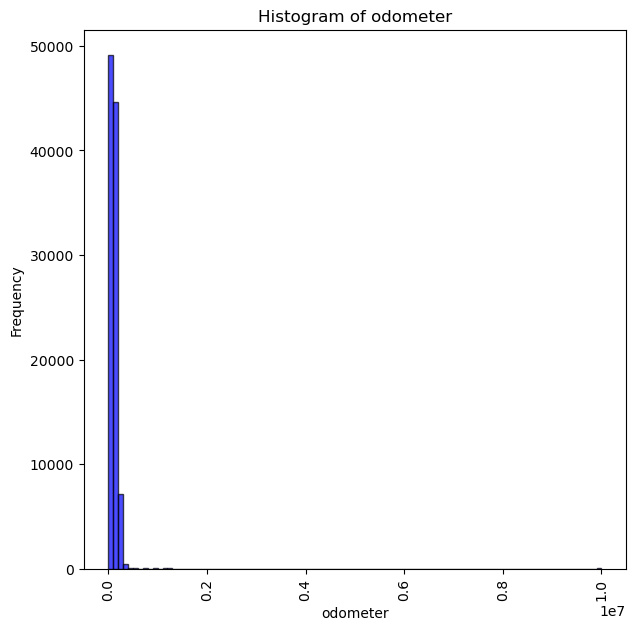

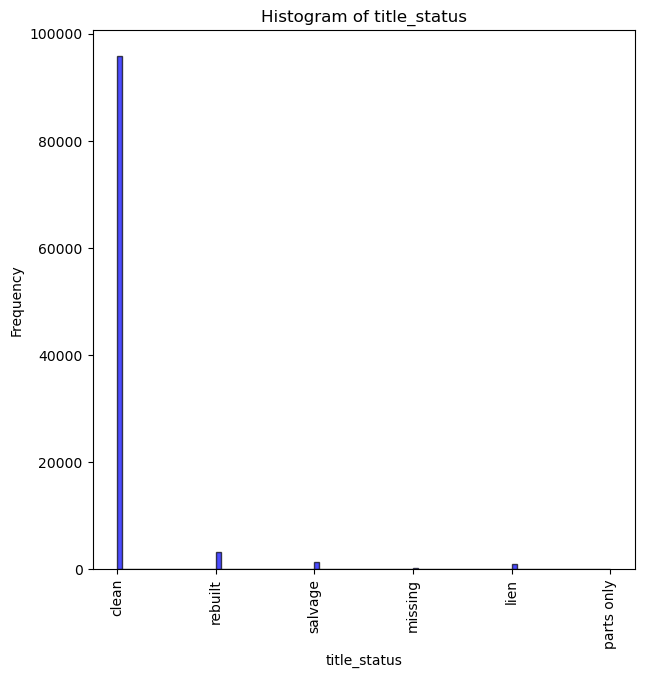

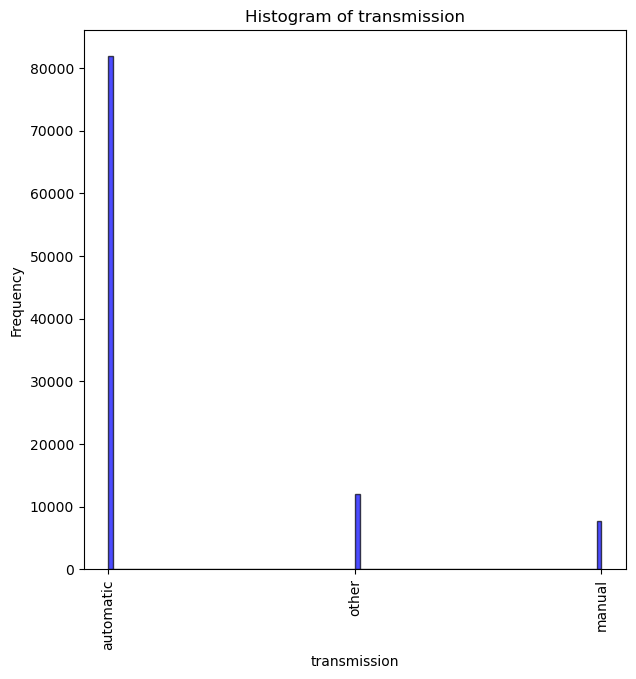

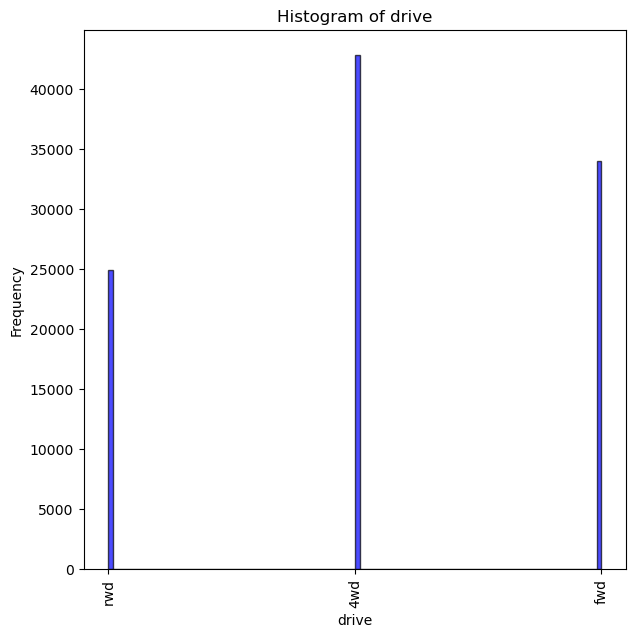

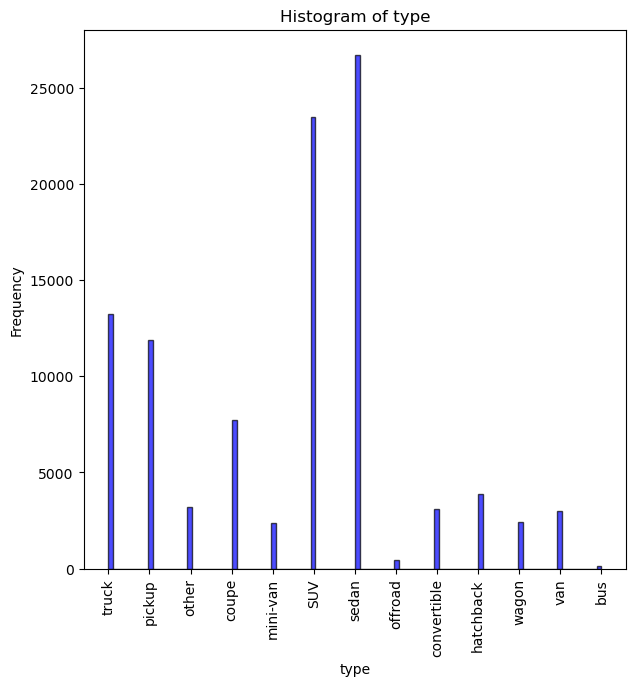

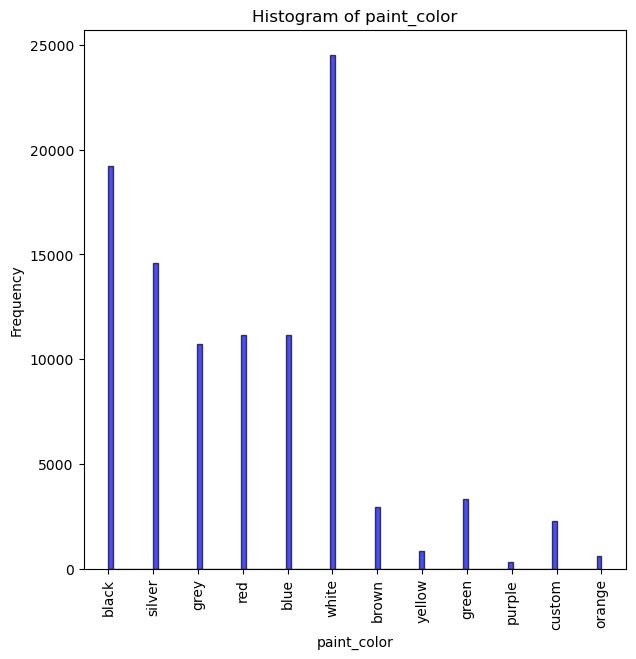

In [10]:
df_clean_hist = pd.DataFrame(df_clean)
#df_clean_hist.drop('model', axis=1, inplace=True) #removing model column

for column in df_clean_hist.columns:
    plt.figure(figsize=(7, 7))
    plt.hist(df_clean_hist[column], bins=100, color='blue', edgecolor='black', alpha=0.7)
    plt.title(f"Histogram of {column}")
    plt.xlabel(column)
    plt.xticks(rotation='vertical')
    plt.ylabel("Frequency")
    plt.show()


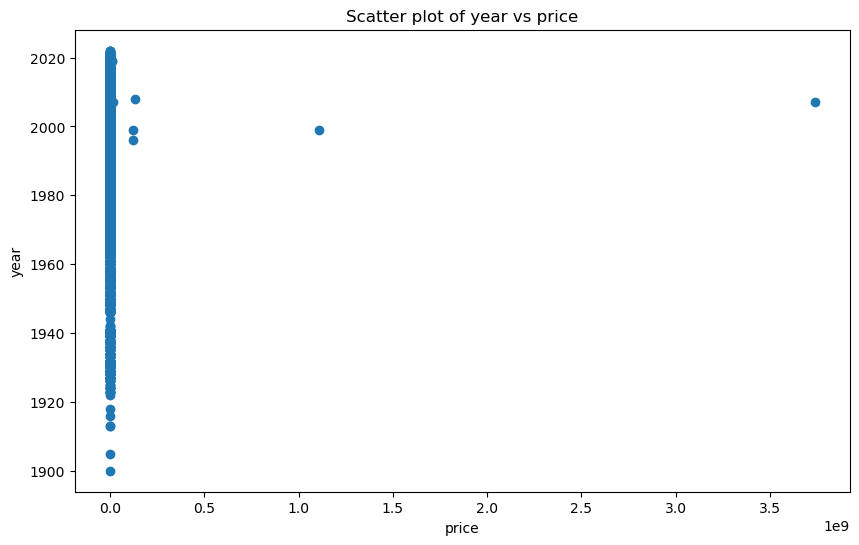

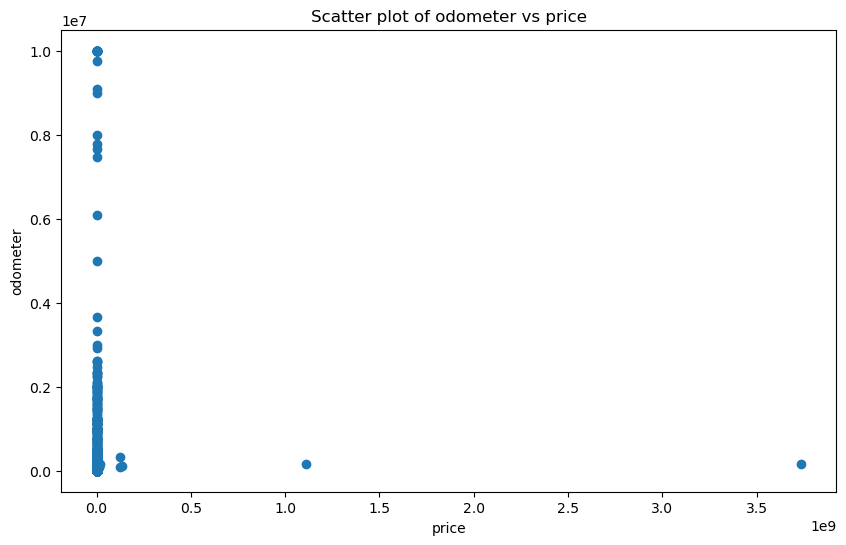

In [11]:
base_parameter = 'price'
other_parameters = [ 'year', 'odometer']  

for param in other_parameters:
    plt.figure(figsize=(10, 6))
    plt.scatter(df_clean[base_parameter], df_clean[param])
    plt.xlabel(base_parameter)
    plt.ylabel(param)
    plt.title(f'Scatter plot of {param} vs {base_parameter}')
    plt.show()

Now, we'll calculate the outliers and remove them

In [12]:
# Calculating the Outliers
first_quartile = df_clean['price'].quantile(.25)  #Round 1 0.25, Round 2 0.10
third_quartile = df_clean['price'].quantile(.75)  #Round 1 0.775, Round 2 0.90
iqr = df_clean['price'].quantile(.75) - df_clean['price'].quantile(.25)
print(f"First Quartile {first_quartile}")
print(f"Third Quartile {third_quartile}")
onehalf_qtr = 1.5*iqr
# If outlier is lower than the lowest value, pick the first quartile
if onehalf_qtr < first_quartile: 
    lower = first_quartile - 1.5*iqr 
else:    
    lower = first_quartile
upper = third_quartile + 1.5*iqr
print(iqr)
print(lower)
print(upper)

First Quartile 6000.0
Third Quartile 23990.0
17990.0
6000.0
50975.0


In [13]:
# Removing the outliers
df_no_outlier = df_clean.loc[(df_clean['price']>lower) & (df_clean['price']<upper)]
df_no_outlier.sort_values(by='price', ascending=True).head(10)
print(f"Total count {df_no_outlier.shape[0]} after removing outliers")

Total count 74330 after removing outliers


Validating the data one more time to confirm outliers are removed.

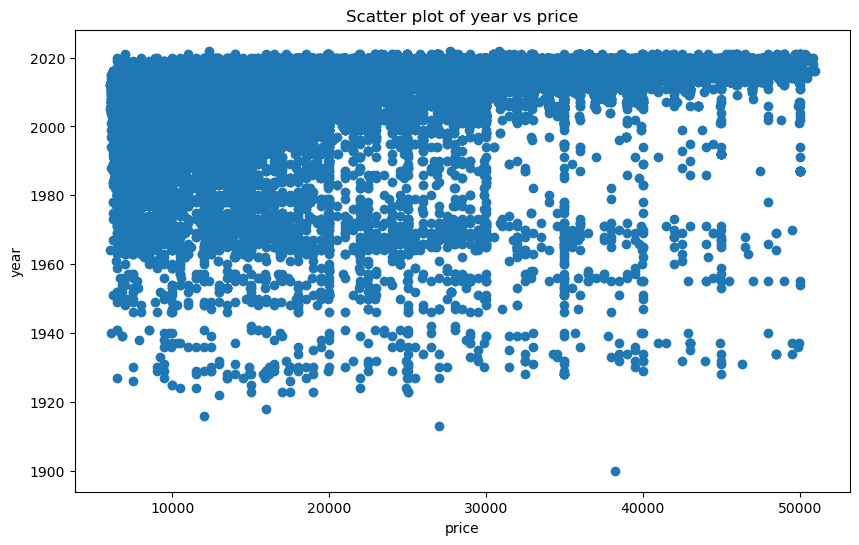

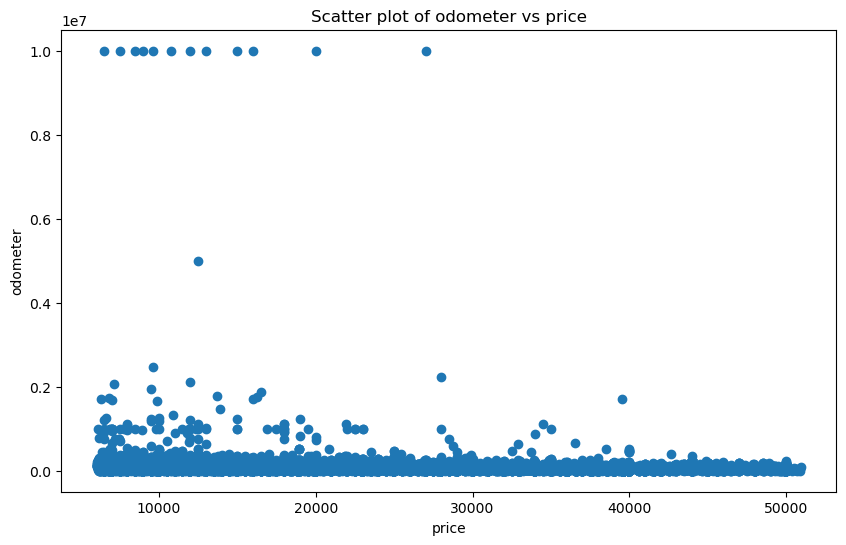

In [14]:
base_parameter = 'price'
other_parameters = [ 'year', 'odometer']  

for param in other_parameters:
    plt.figure(figsize=(10, 6))
    plt.scatter(df_no_outlier[base_parameter], df_no_outlier[param])
    plt.xlabel(base_parameter)
    plt.ylabel(param)
    plt.title(f'Scatter plot of {param} vs {base_parameter}')
    plt.show()

After removing the outliers, our next step is to encode the categorical variables. We will use the OneHotEncoder to encode the categorical variables. We will also use the LabelEncoder to encode the target variable.

In [15]:
column_names = df_no_outlier.select_dtypes(include=['object']).columns
print(column_names)
df_no_outlier.head(10)

Index(['manufacturer', 'condition', 'fuel', 'title_status', 'transmission',
       'drive', 'type', 'paint_color'],
      dtype='object')


,price,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color
id,,,,,,,,,,,,
7316356412,15000,2013,ford,excellent,6,gas,128000.0,clean,automatic,rwd,truck,black
7316343444,27990,2012,gmc,good,8,gas,68696.0,clean,other,4wd,pickup,black
7316304717,34590,2016,chevrolet,good,6,gas,29499.0,clean,other,4wd,pickup,silver
7316285779,35000,2019,toyota,excellent,6,gas,43000.0,clean,automatic,4wd,truck,grey
7316257769,29990,2016,chevrolet,good,6,gas,17302.0,clean,other,4wd,pickup,red
7316133914,38590,2011,chevrolet,good,8,gas,30237.0,clean,other,rwd,other,red
7315816316,32990,2017,jeep,good,6,gas,30041.0,clean,other,4wd,other,silver
7315379459,37990,2016,chevrolet,good,8,gas,9704.0,clean,other,rwd,coupe,red
7315270785,27990,2018,nissan,good,6,gas,37332.0,clean,other,4wd,pickup,silver


In [16]:
#Label Encoding all columns with less than 10 unique values
#Initialize LabelEncoder
le = LabelEncoder()

# Select columns with 10 or less unique values
columns_to_encode = [col for col in df_no_outlier.columns if df_no_outlier[col].nunique() <= 15 and df_no_outlier[col].dtype == 'object']

# Apply LabelEncoder to these columns
for column in columns_to_encode:
    df_no_outlier[column] = le.fit_transform(df_no_outlier[column])
    
df_no_outlier.head(10)

,price,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color
id,,,,,,,,,,,,
7316356412,15000,2013,ford,0,6,2,128000.0,0,0,2,10,0
7316343444,27990,2012,gmc,2,8,2,68696.0,0,2,0,8,0
7316304717,34590,2016,chevrolet,2,6,2,29499.0,0,2,0,8,9
7316285779,35000,2019,toyota,0,6,2,43000.0,0,0,0,10,5
7316257769,29990,2016,chevrolet,2,6,2,17302.0,0,2,0,8,8
7316133914,38590,2011,chevrolet,2,8,2,30237.0,0,2,2,7,8
7315816316,32990,2017,jeep,2,6,2,30041.0,0,2,0,7,9
7315379459,37990,2016,chevrolet,2,8,2,9704.0,0,2,2,3,8
7315270785,27990,2018,nissan,2,6,2,37332.0,0,2,0,8,9


In [17]:
#Performing one hot encoding on the categorical columns
# Round 1 - df_no_outlier_encoded_key_features = pd.get_dummies(df_no_outlier[['id','condition', 'manufacturer', 'fuel', 'title_status', 'transmission', 'size', 'type']]).set_index('id')
columns_to_encode = ['manufacturer']
df_final_encoded = pd.get_dummies(df_no_outlier, columns=columns_to_encode, dtype='int', drop_first=False) #.set_index('id')
df_final_encoded.head(10)
#df_final_encoded.info()

,price,year,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,...,manufacturer_pontiac,manufacturer_porsche,manufacturer_ram,manufacturer_rover,manufacturer_saturn,manufacturer_subaru,manufacturer_tesla,manufacturer_toyota,manufacturer_volkswagen,manufacturer_volvo
id,,,,,,,,,,,,,,,,,,,,,
7316356412,15000,2013,0,6,2,128000.0,0,0,2,10,...,0,0,0,0,0,0,0,0,0,0
7316343444,27990,2012,2,8,2,68696.0,0,2,0,8,...,0,0,0,0,0,0,0,0,0,0
7316304717,34590,2016,2,6,2,29499.0,0,2,0,8,...,0,0,0,0,0,0,0,0,0,0
7316285779,35000,2019,0,6,2,43000.0,0,0,0,10,...,0,0,0,0,0,0,0,1,0,0
7316257769,29990,2016,2,6,2,17302.0,0,2,0,8,...,0,0,0,0,0,0,0,0,0,0
7316133914,38590,2011,2,8,2,30237.0,0,2,2,7,...,0,0,0,0,0,0,0,0,0,0
7315816316,32990,2017,2,6,2,30041.0,0,2,0,7,...,0,0,0,0,0,0,0,0,0,0
7315379459,37990,2016,2,8,2,9704.0,0,2,2,3,...,0,0,0,0,0,0,0,0,0,0
7315270785,27990,2018,2,6,2,37332.0,0,2,0,8,...,0,0,0,0,0,0,0,0,0,0


### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

Principal Component Analysis on the features

In [219]:
# Principal Component Analysis
df_final_encoded_numeric = df_final_encoded.select_dtypes(include=['int64', 'float64'])
df_final_encoded_numeric.head(10)

,price,odometer
id,,
7316356412,15000,128000.0
7316343444,27990,68696.0
7316304717,34590,29499.0
7316285779,35000,43000.0
7316257769,29990,17302.0
7316133914,38590,30237.0
7315816316,32990,30041.0
7315379459,37990,9704.0
7315270785,27990,37332.0


In [25]:


def pca(X, r = 5, column_names = None):
    x_norm =( X - X.mean())/X.std()
    U, sigma, VT = svd(x_norm)
    Sigma = np.diag(sigma)
    Ur = U[:, :r]
    Sigma_r = Sigma[:r, :r]
    if column_names is None:
        column_names = [f'pca_{i}' for i in range(1, r + 1)]
    loadings = pd.DataFrame(VT[:r, :].T, columns=column_names, index=X.columns)
    return pd.DataFrame(Ur @ Sigma_r, columns=column_names), loadings

column_names = df_final_encoded.columns.tolist()
XT, loadings = pca(df_final_encoded, r = 1)
print(XT.shape)
XT.head(100)
print(loadings.all)


<Figure size 800x600 with 0 Axes>

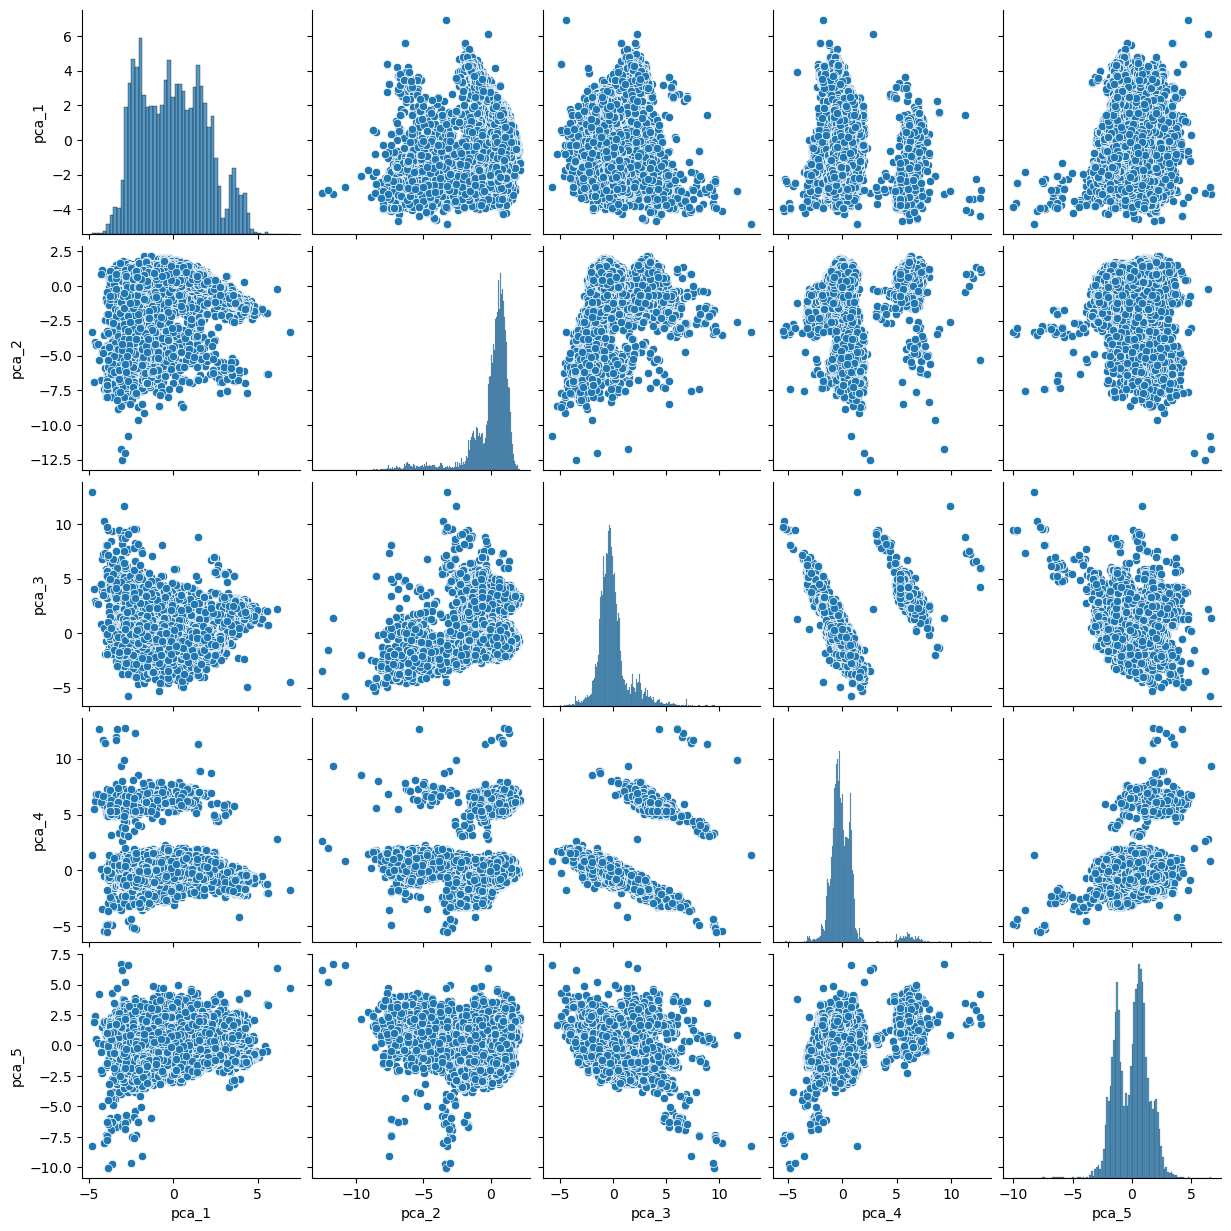

In [ ]:


plt.figure(figsize=(8, 6))
sns.pairplot(XT)
plt.show()

In [35]:
plt.figure(figsize=(10, 10))
corr_matrix = XT.corr()
sns.heatmap(corr_matrix, annot=True)
plt.show()

NameError: name 'XT' is not defined

<Figure size 1000x1000 with 0 Axes>

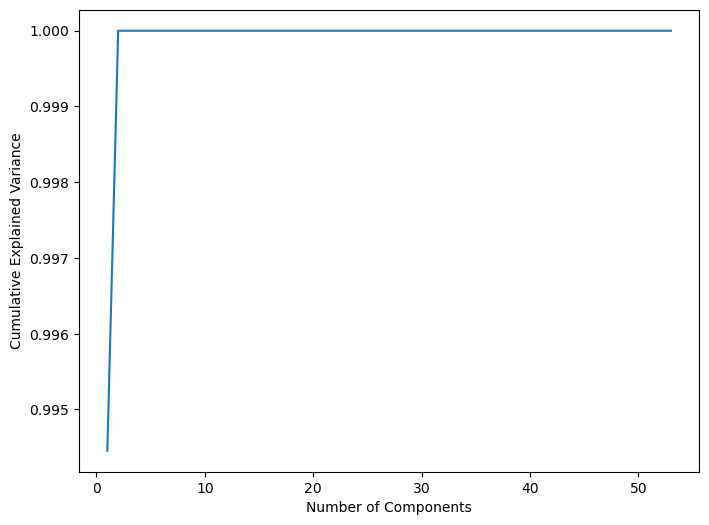

1


In [34]:


# Fit PCA on your data
pca = PCA().fit(df_final_encoded)

# Compute explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Plot explained variance ratio
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), np.cumsum(explained_variance_ratio))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

# Choose number of components that explain a sufficient amount of variance
n_components = np.where(np.cumsum(explained_variance_ratio) > 0.95)[0][0] + 1
print(n_components)
# Reduce your dataset to the chosen number of components
pca = PCA(n_components=n_components)
X_reduced = pca.fit_transform(df_final_encoded)

In [21]:
#==================================================

def singular_values(X, scale = False):
    if scale:
        X = (X - X.mean())/X.std()
        
    u, sigma, vt = svd(X)
    return sigma


print(type(singular_values(df_final_encoded)))
sigma = singular_values(df_final_encoded)
print(sigma.shape)

In [20]:


y = df_final_encoded['price']
X = df_final_encoded.drop('price', axis=1)

all_features_linreg = LinearRegression(fit_intercept=False).fit(X, y)
linreg_mse = mean_squared_error(all_features_linreg.predict(X), y)


# Answer check
print(all_features_linreg)
print(all_features_linreg.coef_)
print(linreg_mse)


LinearRegression(fit_intercept=False)
[ 2.96165227e+02  5.57193239e+02  1.98017588e+03 -2.09436545e+03
 -1.16115343e-02 -3.65037424e+02  5.55816425e+03 -3.42784602e+02
  2.73495923e+01  3.81091672e+01 -5.87348775e+05 -5.77668065e+05
 -5.68405544e+05 -5.85568667e+05 -5.86874228e+05 -5.86211064e+05
 -5.86984905e+05 -5.85161270e+05 -5.90997219e+05 -5.77605801e+05
 -5.87651030e+05 -5.58114603e+05 -5.90367898e+05 -5.85178284e+05
 -5.84976306e+05 -5.87916472e+05 -5.87965319e+05 -5.89337925e+05
 -5.86337368e+05 -5.85909646e+05 -5.84538714e+05 -5.89081240e+05
 -5.87054441e+05 -5.86175225e+05 -5.85288811e+05 -5.88551435e+05
 -5.84537027e+05 -5.88122350e+05 -5.89863408e+05 -5.84300359e+05
 -5.51753886e+05 -5.88285025e+05 -5.83724648e+05 -5.80911998e+05
 -5.82438755e+05 -5.83825668e+05 -5.89419617e+05 -5.87616684e+05
 -5.60524016e+05 -5.85382231e+05 -5.88339518e+05 -5.87582044e+05]
68157446.83038053


In [21]:


X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=42)
selector = SequentialFeatureSelector(LinearRegression(), n_features_to_select=5)
best_features = selector.fit_transform(X_train, y_train)
best_features_df = pd.DataFrame(best_features, columns = selector.get_feature_names_out())
print(best_features_df)

         year  cylinders  fuel  odometer  transmission
0      2004.0        8.0   2.0  177000.0           0.0
1      2011.0        8.0   2.0  124100.0           0.0
2      2019.0        6.0   2.0    8373.0           2.0
3      2020.0        8.0   2.0   42385.0           0.0
4      2017.0        8.0   2.0   35239.0           0.0
...       ...        ...   ...       ...           ...
52026  2020.0        8.0   2.0    1548.0           2.0
52027  2010.0        6.0   2.0   88300.0           0.0
52028  2007.0        8.0   0.0  220570.0           1.0
52029  2019.0        4.0   2.0   47421.0           0.0
52030  2013.0        8.0   2.0   99034.0           0.0

[52031 rows x 5 columns]


In [22]:



pipe = Pipeline([('column_selector', selector),
                ('linreg', LinearRegression())])
pipe.fit(X_train, y_train)
train_preds = pipe.predict(X_train)
test_preds = pipe.predict(X_test)
train_mse = mean_squared_error(y_train, train_preds)
test_mse = mean_squared_error(y_test, test_preds)
### END SOLUTION

# Answer check
print(f'Train MSE: {train_mse: .2f}')
print(f'Test MSE: {test_mse: .2f}')
pipe

Train MSE:  70476193.71
Test MSE:  75727170.84


Pipeline(steps=[('column_selector',
                 SequentialFeatureSelector(estimator=LinearRegression(),
                                           n_features_to_select=5)),
                ('linreg', LinearRegression())])

In [23]:
backward_selector = SequentialFeatureSelector(LinearRegression(), 
                                              n_features_to_select=5,
                                              direction = 'backward')
backward_pipe = Pipeline([('column_selector', backward_selector),
                ('linreg', LinearRegression())])
backward_pipe.fit(X_train, y_train)
train_preds = backward_pipe.predict(X_train)
test_preds = backward_pipe.predict(X_test)
backward_train_mse = mean_squared_error(y_train, train_preds)
backward_test_mse = mean_squared_error(y_test, test_preds)
### END SOLUTION

# Answer check
print(f'Train MSE: {backward_train_mse: .2f}')
print(f'Test MSE: {backward_test_mse: .2f}')
backward_pipe

Train MSE:  70476193.71
Test MSE:  75727170.84


Pipeline(steps=[('column_selector',
                 SequentialFeatureSelector(direction='backward',
                                           estimator=LinearRegression(),
                                           n_features_to_select=5)),
                ('linreg', LinearRegression())])

In [24]:
selected_features = X_train.columns[backward_selector.get_support()]
print(selected_features)

Index(['year', 'cylinders', 'fuel', 'odometer', 'transmission'], dtype='object')


In [25]:


# Assuming X and y are your features and target variable
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

ridge = Ridge(alpha=0.01)  # Initialize Ridge Regression model. You can adjust the alpha parameter as needed.
ridge.fit(X_train, y_train)  # Fit the model on the training data

# Evaluate the model
y_pred = ridge.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')


# Get the coefficients
coefficients = ridge.coef_

# Get the feature importance (absolute value of coefficients)
importance = np.abs(coefficients)

# Get the names of the features from your DataFrame
feature_names = X.columns

# Create a DataFrame for easy viewing
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importance})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

print(feature_importance_df)

Mean Squared Error: 72310262.8209635
                         feature    importance
48            manufacturer_tesla  25511.270272
19           manufacturer_datsun   7908.229320
11       manufacturer_alfa-romeo   7428.663386
18         manufacturer_chrysler   5511.411648
6                   transmission   5449.671973
22             manufacturer_fiat   4467.400677
38             manufacturer_mini   4432.420740
43          manufacturer_porsche   4269.953733
37          manufacturer_mercury   3888.263854
27          manufacturer_hyundai   3818.669868
31              manufacturer_kia   3594.455411
46           manufacturer_saturn   3170.256163
44              manufacturer_ram   3140.549869
50       manufacturer_volkswagen   3040.516815
35            manufacturer_mazda   2868.437516
41           manufacturer_nissan   2713.002740
26            manufacturer_honda   2434.223993
47           manufacturer_subaru   2131.321066
3                           fuel   2095.340478
20            manufactu

In [26]:


# Initialize RFE model
rfe = RFE(estimator=Ridge(alpha=1), n_features_to_select=5)

# Fit the model
rfe.fit(X_train, y_train)

# Transform the data
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

# Train Ridge Regression model on selected features
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_rfe, y_train)

# Evaluate the model
y_pred = ridge.predict(X_test_rfe)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Get the names of the top features selected
top_features = X.columns[rfe.support_]

print(f"The top 5 features selected by RFE are: {top_features}")

Mean Squared Error: 93929668.88560666
The top 5 features selected by RFE are: Index(['transmission', 'manufacturer_fiat', 'manufacturer_mini',
       'manufacturer_ram', 'manufacturer_tesla'],
      dtype='object')


In [27]:

# Define the parameter grid for grid search
param_grid = {
    'linreg__fit_intercept': [True, False]
}

# Create a Pipeline for data processing with linear regression
pipe = Pipeline([
    ('linreg', LinearRegression())
])

# Initialize GridSearchCV
grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Train models using grid search
grid_search.fit(X_train, y_train)

# Get the best estimator from grid search
best_pipe = grid_search.best_estimator_

# Predict y from the transformed test dataset using the best model
y_test_pred = best_pipe.predict(X_test)

# Predict y from the training dataset using the best model
y_train_pred = best_pipe.predict(X_train)

# Calculate mean squared error for test data
mse_test = mean_squared_error(y_test, y_test_pred)
print("Y Test Mean Squared Error:", mse_test)

# Calculate mean squared error for train data
mse_train = mean_squared_error(y_train, y_train_pred)
print("Y Train Mean Squared Error:", mse_train)

# Calculate R-squared (Coefficient of Determination)
r2 = r2_score(y_test, y_test_pred)
print(f"R-squared (Coefficient of Determination): {r2}")

Y Test Mean Squared Error: 139387449.03468758
Y Train Mean Squared Error: 66968771.74637829
R-squared (Coefficient of Determination): -0.12022609576443832


In [30]:
# Add polynomial features
degree = 2  # Change the degree as needed
poly = PolynomialFeatures(degree=degree)
X1_train_poly = poly.fit_transform(X_train)
X1_test_poly = poly.transform(X_test)

# Create a LinearRegression model
linreg = LinearRegression()

# Hyperparameter tuning using GridSearch
param_grid = {
    'fit_intercept': [True, False],
}

grid_search = GridSearchCV(estimator=linreg, param_grid=param_grid, cv=5)
grid_search.fit(X1_train_poly, y_train)

best_linreg = grid_search.best_estimator_

# Train the best model on the training data
best_linreg.fit(X1_train_poly, y_train)

# Predict y from the test dataset using the best model
y1_test_pred_best = best_linreg.predict(X1_test_poly)

# Predict y from the training dataset using the best model
y1_train_pred_best = best_linreg.predict(X1_train_poly)

# Calculate mean squared error for test data using the best model
mse_test_best = mean_squared_error(y_test, y1_test_pred_best)
print("Best Model Y Test Mean Squared Error:", mse_test_best)

# Calculate mean squared error for train data using the best model
mse_train_best = mean_squared_error(y_train, y1_train_pred_best)
print("Best Model Y Train Mean Squared Error:", mse_train_best)

# Calculate R-squared (Coefficient of Determination) for test data using the best model
r2_best = r2_score(y_test, y1_test_pred_best)
print(f"Best Model R-squared (Coefficient of Determination): {r2_best}")

Best Model Y Test Mean Squared Error: 415916688.11856544
Best Model Y Train Mean Squared Error: 48690092.81159646
Best Model R-squared (Coefficient of Determination): -2.3426304227605765


In [32]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer

# Define the number of folds
n_folds = 5

# Create regression models
linear_reg_model = LinearRegression()

# Define the mean squared error as the scoring metric
scorer = make_scorer(mean_squared_error)

# Perform K-Fold Cross-Validation for Linear Regression
linear_reg_scores = cross_val_score(linear_reg_model, X, y, cv=n_folds, scoring=scorer)
linear_reg_mse = linear_reg_scores.mean()



# Print the mean squared error for each model
print("Linear Regression Cross validation X1-Mean Squared Error:", linear_reg_mse)

Linear Regression Cross validation X1-Mean Squared Error: 68955289.08809279


In [33]:
# Define the number of folds
from sklearn.calibration import cross_val_predict


n_folds = 5

# Create a Random Forest Regressor model
lg = LinearRegression()

# Fit the model on your training data
lg.fit(X, y)

# Perform cross-validation to get mean squared error scores
mse_scores = cross_val_score(lg, X, y, cv=n_folds, scoring='neg_mean_squared_error')

# Convert negative scores to positive (mean squared error)
mse_scores = -mse_scores

# Calculate the average mean squared error
average_mse = mse_scores.mean()

# Print the mean squared error for each fold
for i, mse in enumerate(mse_scores):
    print(f"Fold {i+1} Mean Squared Error: {mse}")

# Print the average mean squared error
print("Average Mean Squared Error:", average_mse)

# Perform cross-validation to get predicted target values
predicted_y = cross_val_predict(lg, X, y, cv=n_folds)

# Calculate R-squared
r_squared = lg.score(X, y)

# Print R-squared
print("R-squared (Coefficient of Determination):", r_squared)

# Calculate Mean Squared Error between predicted and actual target values
mse = mean_squared_error(y, predicted_y)
print("Overall Mean Squared Error:", mse)

Fold 1 Mean Squared Error: 72978039.28576383
Fold 2 Mean Squared Error: 67108783.92498054
Fold 3 Mean Squared Error: 69538757.35703965
Fold 4 Mean Squared Error: 66083064.29081706
Fold 5 Mean Squared Error: 69067800.58186285
Average Mean Squared Error: 68955289.08809279
R-squared (Coefficient of Determination): 0.4507110667929175
Overall Mean Squared Error: 68955289.08809279


### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

In [ ]:
# Key Findings
# 1. Of the 426836 records, 35672 records remained after removing null values
# 2. Of those amount, only 25489 records remained after removing outliers
# 3. Once One Hot Encoding of specific columns was done, the number of columns increased to 82
# 4. On evaluating using PCA, with different r values, the variance continued to stay at 1 indicating that all the values are 
#    important and cannot be removed. 
# 5. On using the Linear Regression model, the MSE was very high.
# 6. On using the Sequential Feature Selector, the following features were selected: 
#       a. fuel_diesel  
#       b. type_truck
#       c. year 
#       d. cylinders
#       e. odometer
# 7. On using the Linear Regression model, the train and test MSE was very high indicating that the model is not a good fit.
# 8. On using the Sequential Feature Selector with backward direction, the following features were selected:
#       a. fuel_diesel
#       b. type_truck
#       c. year
#       d. cylinders
#       e. odometer
#    Eventhough the Train and Test MSE were high, the features selected were the same as the Sequential Feature Selector.
# 9. On using the Ridge Regression model, the MSE came high as well. The following top 5 features were selected:
#       a. manufacturer_ferrari
#       b. manufacturer_tesla
#       c. manufacturer_datsun
#       d. manufacturer_aston-martin
#       e. manufacturer_fiat
# 10. On using the Ridge Regression model with RFE, the MSE came high as well. The following top 5 features were selected:
#       a. condition_fair
#       b. manufacturer_alfa-romeo
#       c. manufacturer_ferrari
#       d. manufacturer_tesla
#       e. fuel_diesel
# Based on the above findings, none of the models were able to predict the price of the vehicles accurately.
# The size of the data set after the null record removal was very small and perhaps that is the reason for it not able to predict
# the price accurately. The data set needs to be larger and more features need to be added to the data set to make it more 
# accurate.

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.

In [ ]:
# Based on the current findings, I would not recommend this model to be used for predicting the price of the vehicles. It will
# be better to evaluate the results with a larger data set and more features added to the data set and then evaluate the results again
# to see if the model is able to predict the price of the vehicles accurately.